In [1]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss
from control.matlab import lsim
import random
from tqdm import tqdm
import os

**The Tabular value-fucntion methods on the cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient.

# 1. Given the $\mathcal{X}$, $\mathcal{U}$ of the first hands-on define: the set of possible initial conditions of an episode; the terminal conditions of the episode


The goal of this qlearning algorithm is to start slightly out of balance and try to keep the pole balanced.

The set of all possible initial conditions is:

$$
x =
\left( \begin{array}{ccc}
                  x_1 \\
                  x_2 \\
                  x_3 \\
                  x_4
\end{array} \right)
=
\left( \begin{array}{ccc}
                \theta \in [-1, 1]^\circ \\
                \dot \theta \in [-1, 1] \frac{rad}{s} \\
                p_c \in [-0.1, 0.1] m \\
                \dot p_c \in [-1, 1] \frac{m}{s}
\end{array} \right)
$$

And the terminal episodes are:
1. if the pole is too unbalanced, $|\theta| \geq 10^\circ$
2. if the cart is going too far away $|p_c| \geq 1m$
3. if the control input force is too high $|u| > 10N$
4. If the episode is taking more than $20s$ ($1000$ time steps @ $t_{sample} = 0.02s$)

In [2]:
lowerBounds = [
    deg2rad(-10),
    -1,
    -1,
    -2
]
upperBounds = [- i for i in lowerBounds]
max_steps= 1000

def get_random_initial_state():
    return np.array([np.deg2rad(random.uniform(-1,1)), random.uniform(-1,1), random.uniform(-1,1)/10, random.uniform(-1,1)]) # start out of equilibrium

# 2. Provide a proper discretization of the state space $\mathcal{X}$, and define the size of the action-value function $Q$




To discretise the system, all components of the state will be divided more parts.

In [3]:
numberOfBins = [
    10,
    4,
    4,
    4
]

action_size = 2 # left or right

# 3. Create a code able to select the discretized version of a measured state $x$.


In [4]:
class StateDiscretizer:
    def __init__(self, numberOfBins):
        self.poleAngleBin = np.linspace(lowerBounds[0],upperBounds[0],numberOfBins[0])
        self.poleAngleVelocityBin = np.linspace(lowerBounds[1],upperBounds[1],numberOfBins[1])
        self.cartPositionBin = np.linspace(lowerBounds[2],upperBounds[2],numberOfBins[2])
        self.cartVelocityBin = np.linspace(lowerBounds[3],upperBounds[3],numberOfBins[3])
        self.numberOfBins = numberOfBins


    def discretize_state(self, state):
        angle    =      state[0]
        angularVelocity=state[1]
        position =      state[2]
        velocity =      state[3]

        indexAngle=np.maximum(np.digitize(angle,self.poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(angularVelocity,self.poleAngleVelocityBin)-1,0)
        indexPosition=np.maximum(np.digitize(position,self.cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(velocity,self.cartVelocityBin)-1,0)

        return tuple([indexAngle,indexAngularVelocity,indexPosition,indexVelocity])
    
    def is_terminal_state(self, dstate):
        if dstate[0] == 0 or dstate[0] == self.numberOfBins[0]-1:
            return True
        if dstate[2] == 0 or dstate[2] == self.numberOfBins[2]-1:
            return True
        return False

discretizer = StateDiscretizer(numberOfBins)

# 4.    Given the terminal conditions of the episode (selected in 1.) create a code able to perform a fixed number of episodes of a fixed number of steps, starting from random initial conditions and applying random inputs.

The state discretizer contains a function `is_terminal_state` that checks if the discretized state is a terminal state or not.

## Reward

I tried both sparse reward and dense reward. The discussion about the gotten results are discussed at the bottom of this notebook.

In [5]:
def get_dense_reward(position, boundary):
    return (boundary - abs(position)) / boundary

# 5.   Create a function able to perform $\epsilon$-greedy policy for a chosen $\epsilon$.

In [6]:
def episilon_greedy_policy(epsilon, qtable, state):
    exp_exp_tradeoff = random.uniform(0, 1)
        
    ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
    if exp_exp_tradeoff > epsilon:
        action = np.argmax(qtable[state])

    # Else doing a random choice --> exploration
    else:
        action = random.randint(0,1)

    return action

# 6. Create a code that applies Tabular Q-Learning algorithm.

- If I consider that the cumulated reward of an episode can be expressed as $G_t = R_{t+1} + R_{t+2} + \dots \Rightarrow G_t = R_{t+1} + G_{t+1}$
- I don't know $G_{t+1}$ until the episode is finished, so I use the Qtable to estimate it: $G_t = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1})$


In [7]:
def cart_and_pole_odeint(x, t, F):
    dxdt = np.zeros_like(x)

    dxdt[0] = x[1] #tetap
    dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
    dxdt[2] = x[3] #xp
    dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
    return dxdt

g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

time_step=0.02
t0_odeint=0
t1_odeint = t0_odeint+0.02
t_odeint = np.array([t0_odeint, t1_odeint])


## Parameter choice

### Total episodes

At least 40k episodes, more would be best, but the performance of my algorithm isn't good.

### Learning rate $\alpha$

The learning rate determines the degree to which newly acquired information overrides old information. A higher learning rate means that new information is given more weight, while a lower learning rate means that old information is given more weight.
A general value is around $10^{-3,-4,-5}$.

### Discounting rate $\gamma$

The discount factor determines the importance of future rewards. It typically ranges between 0 and 1, where a value closer to 1 indicates that future rewards are highly valued, and a value closer to 0 indicates that only immediate rewards are valued.
In this case, since the environment is episodic a value close to 1 is preferable.

### Decay rate

The epsilon value is being updated with an exponential decay as the number of episodes increases. The variable `epsilon_decay` is used to keep count of how many iterations the algorithm has already completed. In this way I can load the stored Q-table and improve the performance.

$\epsilon$ has still a lower bound which can be set.

The formula is the following: $\epsilon = min_\epsilon + (max_\epsilon - min_\epsilon)e^{-decay_{rate}*epsilon_{decay}}$


In [8]:
total_episodes = 80000
learning_rate = 0.01
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.0001            # Exponential decay rate for exploration prob

In [9]:
def load_or_init_qtable(file_name):
    if os.path.exists(file_name):
        return np.load(file_name)
    else:
        return np.zeros(tuple(numberOfBins) + (action_size, ))

def save_qtable(qtable, file_name):
    #if os.path.exists(file_name):
    #    os.system(f"mv {file_name} old/`date +\"%Y-%m-%dT%H:%M:%S%z\"`_{file_name}")
    with open(file_name, "wb") as f:
        np.save(f, qtable)

In [10]:
qtable = load_or_init_qtable("qtable.npy")

In [11]:
cumulative_discounted_rewards = []
epsilon_decay = 0

In [12]:
# List of rewards

for episode in tqdm(range(total_episodes)):
    # Reset the environment
    state_c = get_random_initial_state()
    
    state = discretizer.discretize_state(state_c)
    cumulative_discounted_reward = 0
    
    for step in range(max_steps):
        action = episilon_greedy_policy(epsilon, qtable, state)
            
        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10

        # Simulate the system
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretizer.discretize_state(new_state_c)
        
        if discretizer.is_terminal_state(new_state):
            reward = -100
        else:
            reward = 1 # get_dense_reward(new_state[0], lowerBounds[0]) # sparse reward. Close to theta better

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state + (action,)] = qtable[state + (action,)] + \
        learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state + (action,)])
        
        cumulative_discounted_reward += reward * gamma ** step 
        
        # Our new state is state
        state = new_state
        state_c = new_state_c

        
        # If done (if we're dead) : finish episode
        if discretizer.is_terminal_state(new_state):
            break
        
    # Reduce epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epsilon_decay)
    epsilon_decay += 1 
    cumulative_discounted_rewards.append(cumulative_discounted_reward)

    if episode % 5000 == 0:
        print(np.average(cumulative_discounted_rewards[-5000:]), epsilon)
    


print ("Score over time: " +  str(sum(cumulative_discounted_rewards)/total_episodes))
print("Epsilon:", epsilon)

  0%|          | 16/80000 [00:00<08:21, 159.51it/s]

-51.84843270860545 1.0


  6%|▋         | 5020/80000 [00:44<14:31, 86.04it/s] 

-31.6477775203119 0.6104653531155071


 13%|█▎        | 10005/80000 [02:13<31:29, 37.04it/s]

-9.718778772022516 0.3742006467597279


 19%|█▉        | 15013/80000 [04:06<30:30, 35.51it/s]

-2.5794578720744092 0.23089885854694553


 25%|██▌       | 20002/80000 [06:40<31:21, 31.88it/s]  

2.138050395289083 0.1439819304042466


 31%|███▏      | 25008/80000 [09:03<30:26, 30.10it/s]

2.77456668313099 0.0912641486376598


 38%|███▊      | 30005/80000 [12:06<28:32, 29.19it/s]  

3.195277975396935 0.05928919768418531


 44%|████▍     | 35011/80000 [14:23<16:31, 45.37it/s]

2.6279604361643547 0.039895409588095315


 50%|█████     | 40007/80000 [16:46<14:57, 44.56it/s]

3.648990953956941 0.028132482499846838


 56%|█████▋    | 45005/80000 [19:01<18:38, 31.28it/s]

2.992692259964366 0.02099790657285988


 63%|██████▎   | 50009/80000 [21:09<11:17, 44.27it/s]

3.505538390612656 0.016670567529094613


 69%|██████▉   | 55009/80000 [23:27<11:24, 36.51it/s]

3.705436803312412 0.014045903724079427


 75%|███████▌  | 60009/80000 [25:48<07:41, 43.28it/s]

2.9778420415777926 0.012453964654899695


 81%|████████▏ | 65011/80000 [28:45<07:36, 32.81it/s]

3.1484777550742264 0.011488404801047796


 88%|████████▊ | 70007/80000 [32:28<08:05, 20.58it/s]

3.5554045054687937 0.010902763145898971


 94%|█████████▍| 75010/80000 [35:14<02:09, 38.47it/s]

2.808924717459353 0.010547553526446355


100%|██████████| 80000/80000 [37:29<00:00, 35.57it/s]

Score over time: -0.21446779768746227
Epsilon: 0.010332141214084245


Since it's really hard to understand anything from the rewards, I have to 

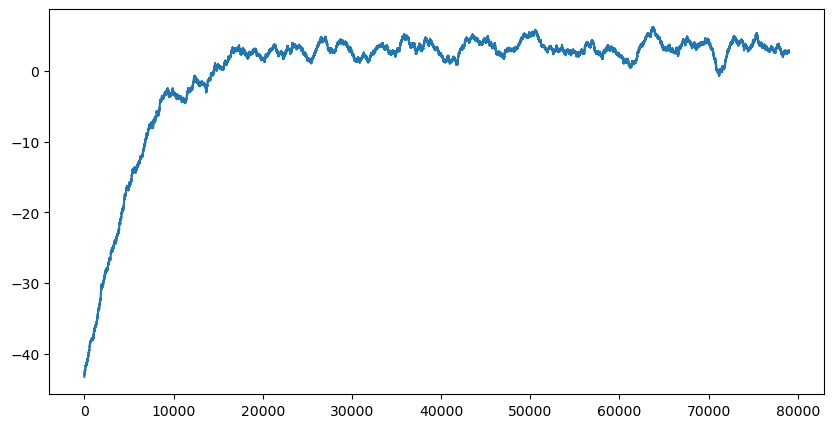

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.convolve(cumulative_discounted_rewards,np.ones(1000)/1000,mode='valid'))

In [14]:
save_qtable(qtable, "qtable.npy")

In [15]:
def simulate_qtable(qtable):
    x0_odeint = get_random_initial_state()
    X_odeint = [x0_odeint]
    uvec = []

    state_c = x0_odeint
    state = discretizer.discretize_state(state_c)
    total_rewards = 0

    for step in range(max_steps):
        action = np.argmax(qtable[state])

        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10
            
        uvec.append(F)

        # Simulate the system
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretizer.discretize_state(new_state_c)
        X_odeint=np.append(X_odeint, [state_c], axis= 0)

        if discretizer.is_terminal_state(new_state):
            reward = -10
        else:
            reward = 1

        total_rewards = total_rewards + reward

        # Our new state is state
        state = new_state
        state_c = new_state_c

        # If done (if we're dead) : finish episode
        if discretizer.is_terminal_state(new_state):
            break
    
    print("Time:", np.arange(0.0, 10, time_step)[:len(uvec)][-1])
    time_sim=np.arange(0.0, 10+time_step, time_step)

    plt.rcParams['figure.figsize'] = [10, 15]
    fig, axs = plt.subplots(5)
    fig.subplots_adjust(hspace=0.5)

    axs[0].plot(np.arange(0.0, 10, time_step)[:len(uvec)], uvec, 'r', label='U(t)')
    axs[0].set_title("U")

    axs[1].plot(time_sim[:X_odeint[:,0].shape[0]], X_odeint[:,0], 'b')
    axs[1].set_title("theta(t)")

    axs[2].plot(time_sim[:X_odeint[:,1].shape[0]], X_odeint[:,1], 'b')
    axs[2].set_title("dot theta(t)")

    axs[3].plot(time_sim[:X_odeint[:,2].shape[0]], X_odeint[:,2], 'b')
    axs[3].set_title("p_c(t)")

    axs[4].plot(time_sim[:X_odeint[:,3].shape[0]], X_odeint[:,3], 'b')
    axs[4].set_title("dot p_c(t)")

Time: 0.68


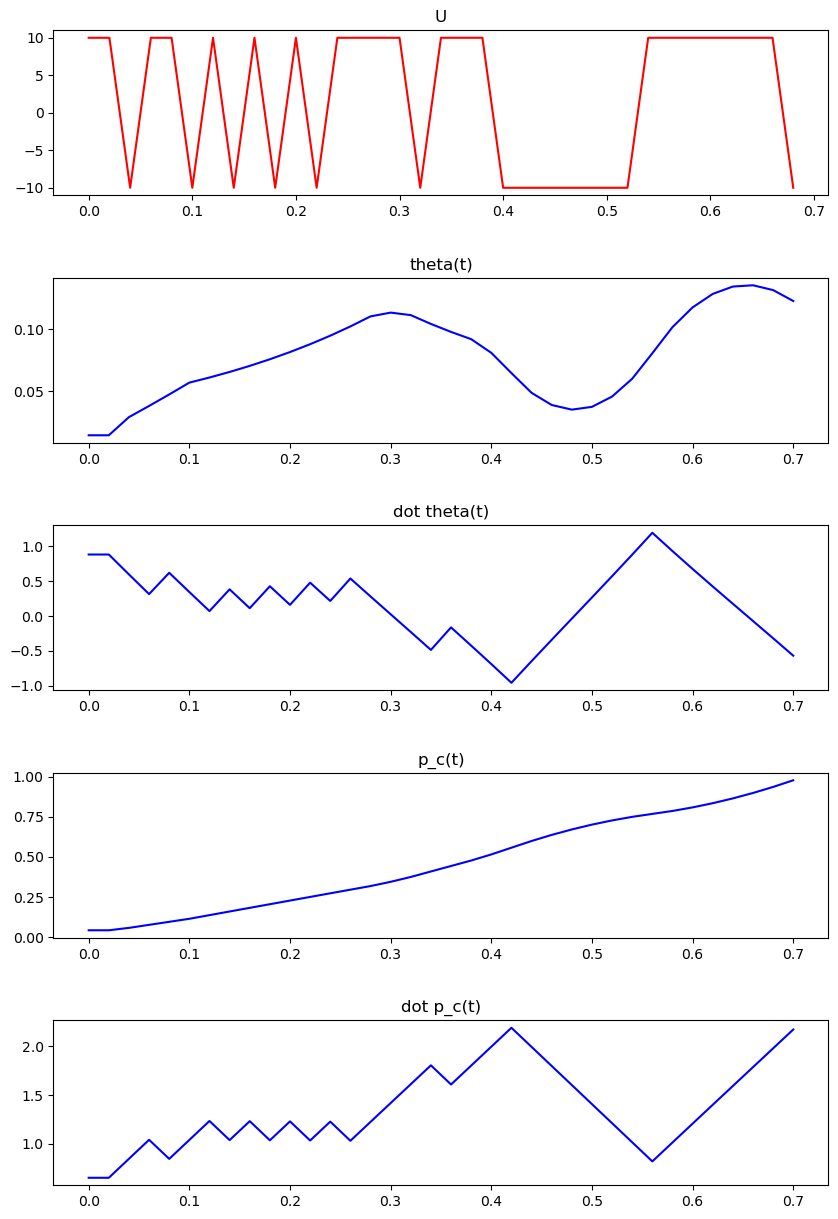

In [16]:
simulate_qtable(qtable)

# 7.    Copy and paste your Q-learning algorithm and apply the changes needed to convert it into a SARSA algorithm

SARSA stands for State-Action-Reward-State-Action.

SARSA works like following:
- To update the Qtable I use the following equation: $Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha ( R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) )$

So for each iteration I need to know:
- $S_t$ and $A_t$ which are the current state and action
- $R_{t+1}$ which is the reward when performing $A_t$ being on $S_t$
- $S_{t+1}$ and $A_{t+1}$, which are the next state and action

In [17]:
qtable_sarsa = load_or_init_qtable("qtable_sarsa.npy")

In [18]:
rewards_sarsa = []
epsilon_decay = 0

In [19]:
for episode in tqdm(range(total_episodes)):
    # Reset the environment
    cumulative_discounted_reward = 0
    state_c = get_random_initial_state()
    state = discretizer.discretize_state(state_c)
    
    action = episilon_greedy_policy(epsilon, qtable_sarsa, state)

    for step in range(max_steps):            
        # convert action into force
        if action == 1:
            F = 10
        else:
            F = -10

        # Simulate the system
        x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
        new_state_c = x_odeint[1]
        new_state = discretizer.discretize_state(new_state_c)

        new_action = episilon_greedy_policy(epsilon, qtable_sarsa, state)

        
        if discretizer.is_terminal_state(new_state):
            reward = -100
        else:
            reward = 1 # get_dense_reward(new_state[0], lowerBounds[0])


        qtable_sarsa[state + (action,)] = qtable_sarsa[state + (action,)] + \
        learning_rate * (reward + gamma * qtable_sarsa[new_state + (new_action,)] - qtable_sarsa[state + (action,)])
        
        cumulative_discounted_reward += reward * gamma ** step
        
        # Our new state is state
        state = new_state
        state_c = new_state_c
        action = new_action

        # If done (if we're dead) : finish episode
        if discretizer.is_terminal_state(new_state):
            break
        
    # Reduce epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epsilon_decay)
    epsilon_decay += 1 
    rewards_sarsa.append(cumulative_discounted_reward)

    if episode % 5000 == 0:
        print(np.average(cumulative_discounted_rewards[-5000:]), epsilon)

print ("Score over time: " +  str(sum(rewards_sarsa)/total_episodes))
print("Epsilon:", epsilon)

  0%|          | 35/80000 [00:00<08:10, 163.07it/s]

3.4495428713066474 1.0


  6%|▋         | 5022/80000 [00:36<10:44, 116.35it/s]

3.4495428713066474 0.6104653531155071


 13%|█▎        | 10011/80000 [01:48<21:34, 54.07it/s]

3.4495428713066474 0.3742006467597279


 19%|█▉        | 15010/80000 [03:36<25:59, 41.68it/s]

3.4495428713066474 0.23089885854694553


 25%|██▌       | 20012/80000 [05:44<18:51, 53.02it/s]

3.4495428713066474 0.1439819304042466


 31%|███▏      | 25013/80000 [07:52<19:15, 47.57it/s]

3.4495428713066474 0.0912641486376598


 38%|███▊      | 30010/80000 [10:04<17:08, 48.60it/s]

3.4495428713066474 0.05928919768418531


 44%|████▍     | 35007/80000 [12:09<18:50, 39.78it/s]

3.4495428713066474 0.039895409588095315


 50%|█████     | 40016/80000 [14:13<14:56, 44.59it/s]

3.4495428713066474 0.028132482499846838


 56%|█████▋    | 45008/80000 [16:21<15:27, 37.73it/s]

3.4495428713066474 0.02099790657285988


 63%|██████▎   | 50007/80000 [18:33<12:53, 38.79it/s]

3.4495428713066474 0.016670567529094613


 69%|██████▉   | 55004/80000 [20:42<13:55, 29.92it/s]

3.4495428713066474 0.014045903724079427


 75%|███████▌  | 60007/80000 [22:37<07:08, 46.61it/s]

3.4495428713066474 0.012453964654899695


 81%|████████▏ | 65009/80000 [24:34<06:52, 36.36it/s]

3.4495428713066474 0.011488404801047796


 88%|████████▊ | 70008/80000 [26:28<04:48, 34.68it/s]

3.4495428713066474 0.010902763145898971


 94%|█████████▍| 75009/80000 [28:40<02:28, 33.64it/s]

3.4495428713066474 0.010547553526446355


100%|██████████| 80000/80000 [30:52<00:00, 43.18it/s]

Score over time: -1.5911287515640278
Epsilon: 0.010332141214084245


In [20]:
save_qtable(qtable_sarsa, "qtable_sarsa.npy")

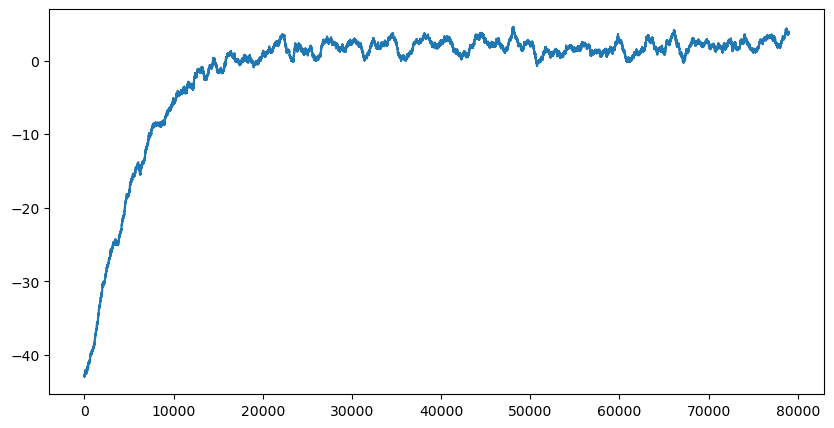

In [21]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(np.convolve(rewards_sarsa,np.ones(1000)/1000,mode='valid'))

Time: 1.24


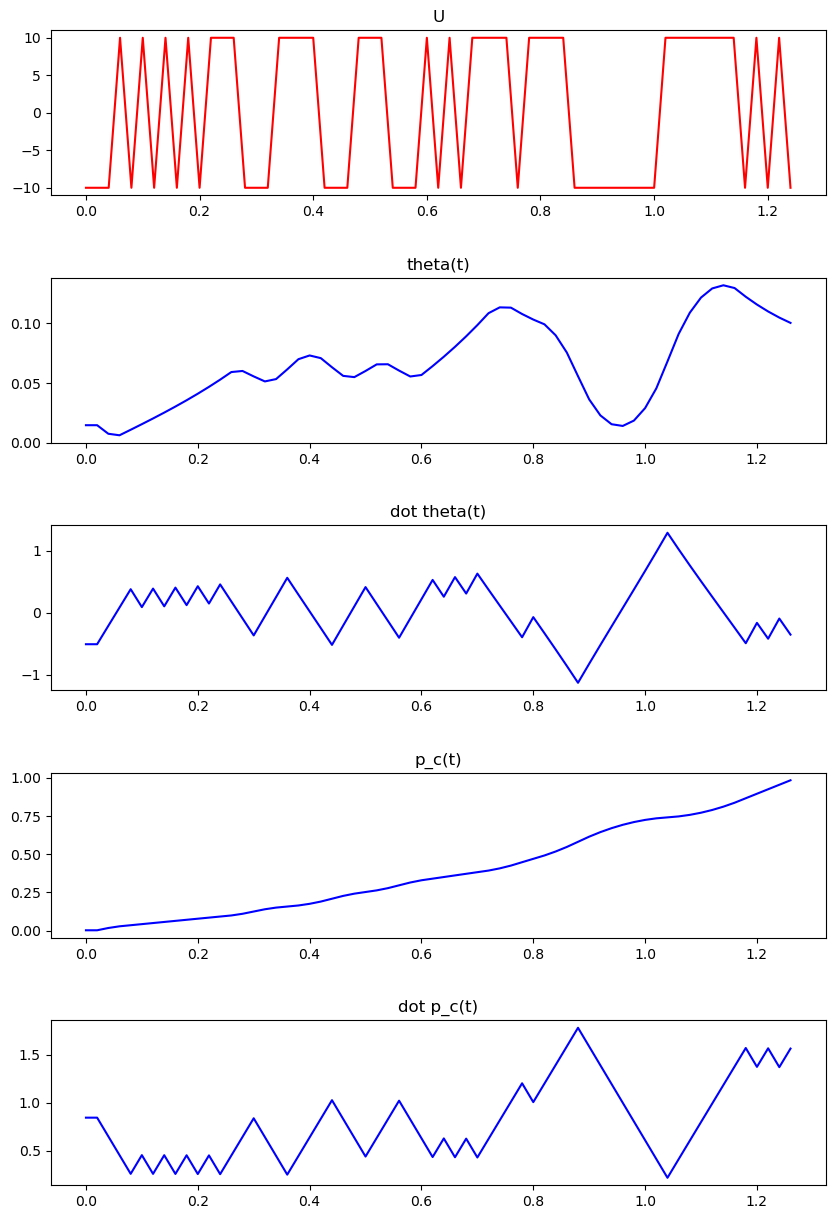

In [22]:
simulate_qtable(qtable_sarsa)

## Comparison of the results

SARSA is having higher rewards, because of its nature, but the time it can keep the pole balanced is not much higher than Qlearning.

## Dense reward function

I tried to implement a dense reward function, but with the naive reward function (+1 when balancing, -100 when felt), I was able to actually have better performance on SARSA and Qlearning. This can be due to the fact that the sparse reward function I chose has local minimums that are not the straight up position.
Another difference I noticed is that the sparse reward is converging to it's maximum value more quickly than the dense reward, which even after 40k iterations is still growing.